In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from natsort import natsorted
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imsave
from sklearn.metrics import confusion_matrix
os.environ['CUDA_VISIBLE_DEVICES']='2'
%matplotlib inline
#http://ankivil.com/kaggle-first-steps-with-julia-chars74k-first-place-using-convolutional-neural-networks/

/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def label2int(ch):
    ascii_val = ord(ch)
    if(ascii_val <= 57): #0-9
        ascii_val -= 48
    elif(ascii_val <= 90): #A-Z
        ascii_val -= 55
    else: #a-z
        ascii_val -= 61
    return ascii_val
def int2label(i):
    if(i <= 9): #0-9
        i += 48
    elif(i<=35): #A-Z
        i += 55
    else: #a-z
        i += 61
    return chr(i)

In [3]:
#图片数据持久化，保存到本地，供下次直接调用
def data_preprocessing(data_path, img_rows=32, img_cols=32):
    if (os.path.exists(data_path + '/' + 'train_' + str(img_rows) +  '_' + str(img_cols) + '.npy') 
        and os.path.exists(data_path + '/' + 'test_' + str(img_rows) +  '_' + str(img_cols) + '.npy') 
        and os.path.exists(data_path + '/' + 'labels.npy')):
        print('data have already processed')
    else:
        ### Image preprocessing ###
        if not os.path.exists(data_path + "/trainResized"):
            os.makedirs(data_path + "/trainResized")
        if not os.path.exists(data_path + "/testResized"):
            os.makedirs(data_path + "/testResized")
        for set_type in ['train', 'test']:
            files = natsorted(glob.glob(data_path + '/' + set_type + '/*'))
            data = np.zeros((len(files), img_rows, img_cols))
            for i, file_path in enumerate(files):
                img = imread(file_path, as_grey=True) #读入的图为[0, 1]图
                img_resized = resize(img, (img_rows, img_cols))
                data[i] = img_resized
                #Save image
                new_name = "/".join(file_path.split("/")[:-1] ) + "Resized/" + file_path.split("/")[-1]
                imsave(new_name, img_resized)
            #Add channel/filter dimension [222, 32, 32] => [222, 1, 32, 32]
            #train_img = np.stack(train_img)[..., None]
            data = data[:, :, :, np.newaxis]
            data = data.astype('float32')
            #data /= 255
            np.save(data_path + '/' + set_type + '_' + str(img_rows) +  '_' + str(img_cols) + '.npy', data)
        ### Labels preprocessing ###
        y_train = pd.read_csv(data_path + '/trainLabels.csv').values[:, 1]
        #Convert one-hot vectors
        Y_train = np.zeros((y_train.shape[0], len(np.unique(y_train))))
        for i in range(y_train.shape[0]):
            Y_train[i][label2int(y_train[i])] = 1
        np.save(data_path + '/' + 'labels.npy', Y_train)
    X_train_all = np.load(data_path + '/' + 'train_' + str(img_rows) +  '_' + str(img_cols) + '.npy')
    Y_train_all = np.load(data_path + '/' + 'labels.npy')
    test_all = np.load(data_path + '/' + 'test_' + str(img_rows) +  '_' + str(img_cols) + '.npy')
    print('Finish')
    return X_train_all, Y_train_all, test_all

In [4]:
data_path = 'data'
X_train_all, Y_train_all, test_all = data_preprocessing(data_path, 32, 32)

data have already processed
Finish


(6283, 32, 32, 1) (6283, 62) (6220, 32, 32, 1)
(32, 32, 1)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


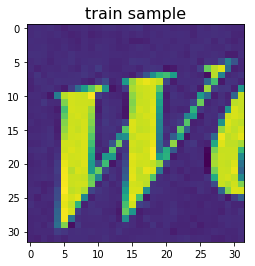

In [5]:
print(X_train_all.shape, Y_train_all.shape, test_all.shape)
sample_x = X_train_all[5]
print(X_train_all[5].shape)
print(Y_train_all[5])
plt.title('train sample', size=16)
plt.imshow(sample_x[..., 0])

In [6]:
### 划分验证集 ###
#数据预处理 方法二
VALIDATION_SIZE = 200    #验证集大小
x_val, y_val = X_train_all[:VALIDATION_SIZE], Y_train_all[:VALIDATION_SIZE]
x_train, y_train = X_train_all[VALIDATION_SIZE:], Y_train_all[VALIDATION_SIZE:]
print(x_train.shape, x_val.shape)
print(y_val[0].shape)

(6083, 32, 32, 1) (200, 32, 32, 1)
(62,)


In [7]:
###定义模型###
def model(x, classes, is_training):
    with tf.variable_scope('layer1-conv'):
        conv1 = tf.layers.conv2d(x, 128, 3, strides=1, padding='SAME')
        norm1 = tf.layers.batch_normalization(conv1, center=True, scale=True, training=is_training)
        relu1 = tf.nn.relu(norm1)
    with tf.variable_scope('layer2-conv-pool'):
        conv2 = tf.layers.conv2d(relu1, 128, 3, strides=1, padding='SAME')
        norm2 = tf.layers.batch_normalization(conv2, center=True, scale=True, training=is_training)
        relu2 = tf.nn.relu(norm2)
        pool2 = tf.layers.max_pooling2d(relu2, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer3-conv'):
        conv3 = tf.layers.conv2d(pool2, 256, 3, strides=1, padding='SAME')
        norm3 = tf.layers.batch_normalization(conv3, center=True, scale=True, training=is_training)
        relu3 = tf.nn.relu(norm3)
    with tf.variable_scope('layer4-conv-pool'):
        conv4 = tf.layers.conv2d(relu3, 256, 3, strides=1, padding='SAME')
        norm4 = tf.layers.batch_normalization(conv4, center=True, scale=True, training=is_training)
        relu4 = tf.nn.relu(norm4)
        pool4 = tf.layers.max_pooling2d(relu4, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer5-conv'):
        conv5 = tf.layers.conv2d(pool4, 512, 3, strides=1, padding='SAME')
        norm5 = tf.layers.batch_normalization(conv5, center=True, scale=True, training=is_training)
        relu5 = tf.nn.relu(norm5)
    with tf.variable_scope('layer6-conv'):
        conv6 = tf.layers.conv2d(relu5, 512, 3, strides=1, padding='SAME')
        norm6 = tf.layers.batch_normalization(conv6, center=True, scale=True, training=is_training)
        relu6 = tf.nn.relu(norm6) 
    with tf.variable_scope('layer7-conv-pool'):
        conv7 = tf.layers.conv2d(relu6, 512, 3, strides=1, padding='SAME')
        norm7 = tf.layers.batch_normalization(conv7, center=True, scale=True, training=is_training)
        relu7 = tf.nn.relu(norm7)
        pool7 = tf.layers.max_pooling2d(relu7, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer8-FC'):
        flatten = tf.reshape(pool7, [-1, 4*4*512])
        affine8 = tf.layers.dense(flatten, 4096)
        norm8 = tf.layers.batch_normalization(affine8, center=True, scale=True, training=is_training)
        relu8 = tf.nn.relu(norm8)
        if is_training == True:
            relu8 = tf.layers.dropout(relu8, 0.5)   
    with tf.variable_scope('layer9-FC'):
        affine9 = tf.layers.dense(relu8, 4096)
        norm9 = tf.layers.batch_normalization(affine9, center=True, scale=True, training=is_training)
        relu9 = tf.nn.relu(norm9)
        if is_training == True:
            relu9 = tf.layers.dropout(relu9, 0.5)
    with tf.variable_scope('layer10-FC'):
        output = tf.layers.dense(relu9, classes)
    return output

In [10]:
### 训练 ###
#训练参数
BATCH_SIZE = 128
EPOCHS = 500             #迭代次数
EARLY_STOP_PATIENCE = 100 #控制early stopping的参数

tf.reset_default_graph()
x_data = tf.placeholder(tf.float32, [None, 32, 32, 1])
y_data = tf.placeholder(tf.float32, [None, 62])
is_training = tf.placeholder(tf.bool)
ckpt_path = './model/mode.ckpt'

predict = model(x_data, 62, is_training)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predict, labels=y_data))
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    best_validation_loss = 1000000.0
    current_epoch = 0
    
    epoch = EPOCHS
    batch_size = BATCH_SIZE
    train_size = len(x_train)
    train_index = list(range(train_size))
    for n in range(epoch):
        random.shuffle(train_index)  # 每个epoch都shuffle一下效果更好
        x_train_, y_train_ = x_train[train_index], y_train[train_index]
        #添加交叉验证
        #x_train, x_val, y_train, y_val = train_test_split(train_img, train_y, test_size=0.1, random_state=42, shuffle=True)
        for i in range(0, train_size, batch_size):
            x_batch = x_train_[i : i + batch_size]
            y_batch = y_train_[i : i + batch_size]
            _, loss_step = sess.run([train_step, loss], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
        if n % 5 == 0:
            validation_loss = loss.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
            print("epoch %d train loss is %f validataion loss is %f" % (n, loss_step, validation_loss))
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            current_epoch = n
            saver.save(sess, ckpt_path)
        elif (n - current_epoch) >= EARLY_STOP_PATIENCE:
            print('early stoping')
            break  

epoch 0 train loss is 3.481383 validataion loss is 48.421124
epoch 5 train loss is 0.774207 validataion loss is 2.018104
epoch 10 train loss is 0.244901 validataion loss is 1.319927
epoch 15 train loss is 0.087827 validataion loss is 1.340053
epoch 20 train loss is 0.121914 validataion loss is 1.553443
epoch 25 train loss is 0.247994 validataion loss is 1.715017
epoch 30 train loss is 0.019208 validataion loss is 1.698038
epoch 35 train loss is 0.037844 validataion loss is 2.254268
epoch 40 train loss is 0.018411 validataion loss is 1.798746
epoch 45 train loss is 0.112877 validataion loss is 1.908942
epoch 50 train loss is 0.039583 validataion loss is 1.935814
epoch 55 train loss is 0.077879 validataion loss is 1.719483
epoch 60 train loss is 0.016703 validataion loss is 1.678846
epoch 65 train loss is 0.000784 validataion loss is 1.385618
epoch 70 train loss is 0.000255 validataion loss is 1.403576
epoch 75 train loss is 0.000041 validataion loss is 1.424350
epoch 80 train loss is 0.

In [28]:
### 计算混淆矩阵  ###
def testModel(ckpt_path):
    tf.reset_default_graph()#mo
    x_data = tf.placeholder(tf.float32, [None, 32, 32, 1])
    y_data = tf.placeholder(tf.float32, [None, 62])
    is_training = tf.placeholder(tf.bool)
    out = model(x_data, 62, is_training)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, 1), tf.argmax(y_data, 1)), tf.float32))
    saver = tf.train.Saver() 
    with tf.Session() as sess:
        saver.restore(sess, ckpt_path)
        #sess.run(out, feed_dict={x_data:x_val, y_data:y_val, is_training:False})
        y_hat = out.eval({x_data: x_val, is_training:False})
        y_pred = np.argmax(y_hat, axis=1)
        y_true = np.argmax(y_val, axis=1)
        cm = confusion_matrix(y_true, y_pred)
        '''
        for i in range(cm.shape[0]):# 混淆矩阵
            for j in range(cm.shape[1]):
                print(cm[i][j], end=' ')
            print('\n')
        '''
        print(cm)
        acc = accuracy.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
        print(acc)

In [29]:
ckpt_path = "./model/mode.ckpt"
testModel(ckpt_path)

INFO:tensorflow:Restoring parameters from ./model/mode.ckpt
[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
0.73


In [14]:
### Submit ###
def submit(model_save_path, output_file):
    tf.reset_default_graph()
    x_test_data = tf.placeholder(tf.float32, [None, 32, 32, 1])
    is_training = tf.placeholder(tf.bool)
    logits = model(x_test_data, 62, is_training)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, model_save_path)
        
        y_pred = []
        test_size = len(test_all)
        batch_size = 1
        for i in range(0, test_size, batch_size):
            x_test_batch = test_all[i*batch_size : (i+1)*batch_size]
            y_hat = logits.eval({x_test_data: x_test_batch, is_training:False})
            y_pred_batch = np.argmax(y_hat, axis=1)
            #vInt2label = np.vectorize(int2label)
            y_pred.append(int2label(y_pred_batch))      
        with open(output_file, 'w') as f:
            f.write('ID,Class\n')
            for i in range(len(y_pred)):
                f.write("".join([str(i+6284), ',', y_pred[i], '\n']))
        print('Finish!')

In [15]:
model_save_path = "./model/mode.ckpt"
output_file = "submission.csv"
submit(model_save_path, output_file)

INFO:tensorflow:Restoring parameters from ./model/mode.ckpt
Finish!
